In [1]:
%matplotlib inline
import matplotlib.style as style

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

import scqubits as scq
import qutip as qt

from PulseSequence import PulseSequence
from QSwitch import QSwitch

style.use('default')
plt.rcParams['figure.figsize'] = [9.7, 6]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
scq.settings.PROGRESSBAR_DISABLED = True

In [2]:
hbar = 1
h = hbar*2*np.pi
qe = 1

# Unit conversions
MHz = 10.0**(-3)
GHz = 1.0
kHz = 10.0**(-6)
us = 10.0**3
ns = 1.0

In [3]:
# q_in, q_switch, q_out1, q_out2
# EJs = [21, 20, 22, 21.5]
# ECs = [0.25, 0.35, 0.35, 0.28]
# gs = [0.1, 0.1, 0.1] # g12, g23, g24
EJs = [22, 21, 24, 23]
ECs = [0.25, 0.4, 0.28, 0.35]
gs = [0.15, 0.12, 0.1] # g12, g23, g24
cutoffs = [4, 5, 4, 4]
isCavity = [False, False, False, False]

qram = QSwitch(
    EJs=EJs,
    ECs=ECs,
    gs=gs,
    cutoffs=cutoffs,
    isCavity=isCavity,
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print(qubit_freqs[0], qubit_freqs[1], qubit_freqs[2], qubit_freqs[3])
print(alphas[0], alphas[1], alphas[2], alphas[3])

6.372742057696335 7.77498011533865 7.040177663718682 7.657605339924338
-0.27581343076221465 -0.4576807972507133 -0.30938459812576546 -0.39344418225938504


In [4]:
# MAKE SURE DRESSED STATES ARE MAPPED CORRECTLY, AT LEAST FOR <= n EXCITATIONS

qram.check_state_mapping(n=3)

100%|██████████| 320/320 [00:51<00:00,  6.19it/s]

Good enough for dressed states mappings.


True

In [5]:
seq = PulseSequence(start_time=0)
# wd1 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.17)
# wd2 = qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.01)
# wd3 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggeg', amp=0.08)
# wd4 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', wd=wd1, amp=0.17)
# wd5 = qram.add_sequential_pi_pulse(seq, 'ggeg', 'geeg', amp=0.01) # should be same as wd2
# wd6 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggge', amp=0.01)
# wd7 = qram.add_sequential_pi_pulse(seq, 'ggge', 'gege', amp=0.01) # should be same as wd2 and should also drive geeg -> ggeg


wd1 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.17)
wd2 = qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.01)
wd3 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggeg', amp=0.08)
wd4 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', wd=wd1, amp=0.17)
wd5 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggge', amp=0.01)
wd7 = qram.add_sequential_pi_pulse(seq, 'ggge', 'gege', amp=0.02)

# qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.12)
# qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggeg', amp=0.04)
# qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.07)
# qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.12) # repeat of pulse 0
# qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggge', amp=0.18)

# seq.wait(50)

# qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggge', amp=0.18)
# qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.12) # repeat of pulse 0
# qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.07)
# qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggeg', amp=0.04)
# qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.12)


# qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.07)
# qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggeg', amp=0.03)
# qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.04)
# qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.07)
# qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggge', amp=0.06)

# seq.wait(50)

# qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggge', amp=0.06)
# qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.07)
# qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.04)
# qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggeg', amp=0.03)
# qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.07)

	new overlap 0.9320232507919739 wd 55.386453872229566
	new overlap 0.9667935503027854 wd 55.33645387222957
	new overlap 0.9897916957142605 wd 55.35645387222957
	new overlap 0.989884760664471 wd 55.35445387222957
updated wd from 8.815027914096582 to 8.809934955917642
	new overlap 0.9992988305307394 wd 49.27220485747124
updated wd from 7.841914960103044 to 7.841914960103044
	new overlap 0.9817911173495697 wd 51.208240558568555
	new overlap 0.9817911173495697 wd 51.208240558568555
	new overlap 0.9896540627257224 wd 51.18824055856855
	new overlap 0.9897076426310939 wd 51.18624055856855
updated wd from 8.150044611935066 to 8.146543203187044
	new overlap 0.9981144269740256 wd 47.51267741598356
updated wd from 7.561877470284444 to 7.561877470284444
	new overlap 0.998713190336463 wd 49.90274630164511
updated wd from 7.942268747767618 to 7.942268747767618


[8.809934955917642, 7.841914960103044, 8.146543203187044, 8.809934955917642, 7.561877470284444, 7.942268747767618] (GHz)
[53.85915467402073, 57.6119641634081, 26.4922324969258, 53.85915467402073, 60.62513823043853, 42.79583818013063] (ns)
total pulse length 295.2434824189445 ns


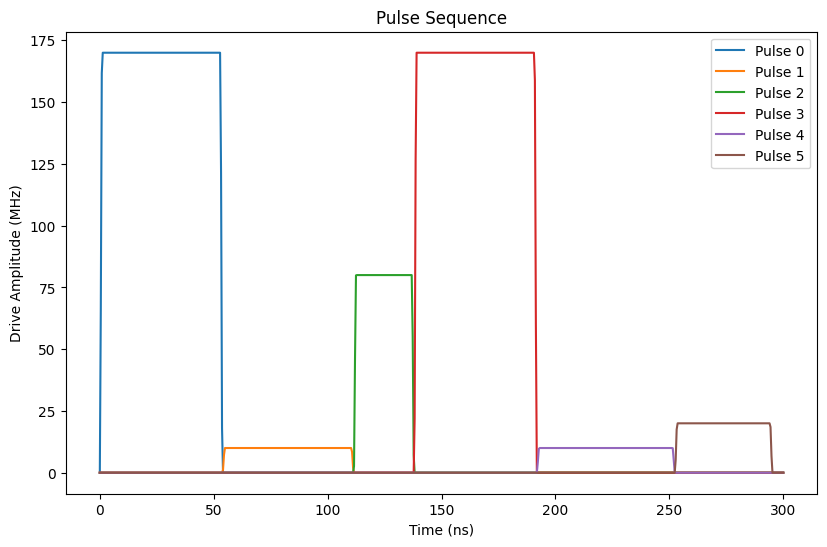

In [6]:
# times = np.linspace(0, 650, 200)
# times = np.linspace(0, 1000, 400)
times = np.linspace(0, 300, 700)
# times = np.linspace(0, 50, 100)

envelope_seq = seq.get_envelope_seq()
print(seq.get_pulse_freqs(), '(GHz)')
print(seq.get_pulse_lengths(), '(ns)')
print('total pulse length', sum(seq.get_pulse_lengths()), 'ns')
for i in range(len(envelope_seq)):
    plt.plot(times, [envelope_seq[i](t)/MHz for t in times], label=f'Pulse {i}')
plt.xlabel('Time (ns)')
plt.ylabel('Drive Amplitude (MHz)')
plt.title('Pulse Sequence')
plt.legend()
plt.show()

In [7]:
# incl_dissipation = True
incl_dissipation = False

T1 = 60e3 # ns
T2 = 30e3 # ?

# T1 = 10e3

c_ops = [
    np.sqrt(1/T1)*qram.a,
    np.sqrt(1/T1)*qram.b,
    np.sqrt(1/T1)*qram.c,
    np.sqrt(1/T1)*qram.d,
]

In [8]:
# psi0_name = 'eggg'
# psi0_name = 'gfgg'
# psi0_name = 'efgg'
# psi0_name = 'eegg'
# psi0_name = 'ggeg'
# psi0_name = 'ggge'

# psi0 = qram.state(psi0_name)
psi0 = np.sqrt(0.4) * qram.state('eggg') + np.sqrt(0.6) * qram.state('eegg') # QRAM start
# psi0 = np.sqrt(0.4) * qram.state('gggg') + np.sqrt(0.6) * qram.state('gegg') # QRAM start

# print(seq.get_pulse_str())

if incl_dissipation:
    full_result = qt.mcsolve(qram.H_solver_str(seq), psi0, times, c_ops, progress_bar=True, options=qt.Options(nsteps=10000))
    result = np.sum(full_result.states, axis=0)/full_result.ntraj
else:
    # result = qt.mesolve(qram.H_solver(seq), psi0, times, progress_bar=True, options=qt.Options(nsteps=10000)).states
    result = qt.mesolve(qram.H_solver_str(seq), psi0, times, progress_bar=True, options=qt.Options(nsteps=12000)).states

10.0%. Run time:   7.99s. Est. time left: 00:00:01:11
20.0%. Run time:  16.14s. Est. time left: 00:00:01:04
30.0%. Run time:  24.08s. Est. time left: 00:00:00:56
40.0%. Run time:  32.39s. Est. time left: 00:00:00:48
50.0%. Run time:  40.72s. Est. time left: 00:00:00:40
60.0%. Run time:  49.26s. Est. time left: 00:00:00:32
70.0%. Run time:  57.64s. Est. time left: 00:00:00:24
80.0%. Run time:  66.14s. Est. time left: 00:00:00:16
90.0%. Run time:  74.43s. Est. time left: 00:00:00:08
Total run time:  83.33s


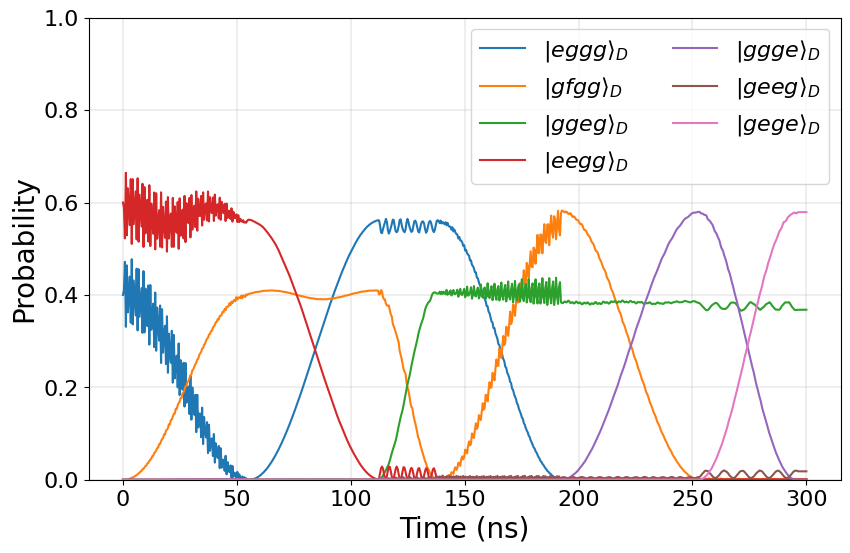

In [13]:
# states for 1 input
eggg = qram.state('eggg')
gfgg = qram.state('gfgg')
ggeg = qram.state('ggeg')
eegg = qram.state('eegg')
ggge = qram.state('ggge')
geeg = qram.state('geeg')
gege = qram.state('gege')
prob_eggg = [np.abs(eggg.overlap(result[t]))**2 for t in range(len(times))]
prob_gfgg = [np.abs(gfgg.overlap(result[t]))**2 for t in range(len(times))]
prob_ggeg = [np.abs(ggeg.overlap(result[t]))**2 for t in range(len(times))]
prob_eegg = [np.abs(eegg.overlap(result[t]))**2 for t in range(len(times))]
prob_ggge = [np.abs(ggge.overlap(result[t]))**2 for t in range(len(times))]
prob_geeg = [np.abs(geeg.overlap(result[t]))**2 for t in range(len(times))]
prob_gege = [np.abs(gege.overlap(result[t]))**2 for t in range(len(times))]

# states for 0 input
gggg = qram.state('gggg')
gegg = qram.state('gegg')
prob_gggg = [np.abs(gggg.overlap(result[t]))**2 for t in range(len(times))]
prob_gegg = [np.abs(gegg.overlap(result[t]))**2 for t in range(len(times))]


plt.plot(times, prob_eggg, label=r'$|eggg\rangle_D$')
plt.plot(times, prob_gfgg, label=r'$|gfgg\rangle_D$')
plt.plot(times, prob_ggeg, label=r'$|ggeg\rangle_D$')
plt.plot(times, prob_eegg, label=r'$|eegg\rangle_D$')
plt.plot(times, prob_ggge, label=r'$|ggge\rangle_D$')
plt.plot(times, prob_geeg, label=r'$|geeg\rangle_D$')
plt.plot(times, prob_gege, label=r'$|gege\rangle_D$')

# plt.plot(times, prob_gggg, label=r'$|gggg\rangle_D$')
# plt.plot(times, prob_gegg, label=r'$|gegg\rangle_D$')

# plt.plot(times, [np.abs(state('geeg').overlap(result[t]))**2 for t in range(len(times))], 'k--', label=r'$|geeg\rangle_D$')
# plt.plot(times, [np.abs(state('efgg').overlap(result[t]))**2 for t in range(len(times))], 'k-.', label=r'$|efgg\rangle_D$')

# for i1 in range(cutoffs[0]):
#     for i2 in range(cutoffs[1]):
#         for i3 in range(cutoffs[2]):
#             for i4 in range(cutoffs[3]):
#                 # print(qram.levels_nums_to_name([i1, i2, i3, i4]))
#                 plt.plot(times, 
#                          [np.abs(qram.state([i1, i2, i3, i4]).overlap(result[t]))**2 for t in range(len(times))],
#                          label='qram.level_nums_to_name[i1, i2, i3, i4]')

# plt.plot(times, [0.5]*len(times), 'k--', linewidth=0.5)
plt.legend(fontsize=16, ncol=2)
plt.ylim(0, 1)
# plt.xlim(750, 1000)
plt.tick_params(labelsize=16)
plt.xlabel('Time (ns)', fontsize=20)
plt.ylabel('Probability', fontsize=20)
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)
plt.show()

In [11]:
T = 300 # ns

sum_psi = 0
T = np.argmin(np.abs(times-T))
print("Non-zero levels:")
for i1 in range(cutoffs[0]):
    for i2 in range(cutoffs[1]):
        for i3 in range(cutoffs[2]):
            for i4 in range(cutoffs[3]):
                prob = np.abs(qram.state([i1, i2, i3, i4]).overlap(result[T]))**2
                sum_psi += prob
                if prob > 0.01: print(qram.level_nums_to_name([i1, i2, i3, i4]), prob)
print('Sum probabilities:', sum_psi)

Non-zero levels:
gggf 0.025309712272326066
ggeg 0.36791709562896896
gege 0.5791562585026541
geeg 0.01816024203908227
Sum probabilities: 1.000075229429106


In [12]:
print('want', qram.get_wd('ggge', 'gege', 0.02)/2/np.pi)
print('want', qram.get_wd('ggeg', 'geeg', 0.02)/2/np.pi)
# print('resonant to', qram.get_wd('ggeg', 'geeg', 0.05)/2/np.pi)
# print('2 photon transition to', qram.get_base_wd('eggg', 'efgg')/2/np.pi)

	new overlap 0.998713190336463 wd 49.90274630164511
updated wd from 7.942268747767618 to 7.942268747767618
want 7.942268747767618
	new overlap 0.9657371815171913 wd 49.10550989112465
	new overlap 0.9657371815171913 wd 49.10550989112465
	new overlap 0.9719299850494143 wd 49.09550989112465
	new overlap 0.9721918453220263 wd 49.09350989112465
updated wd from 7.815384632220447 to 7.813474772903344
want 7.813474772903344
